# Analyzing Car Theft Patterns

Car theft is a persistent issue globally, necessitating a thorough understanding of its patterns and trends. This analysis examines a dataset encompassing vehicle characteristics, theft dates, and make details to uncover insights. By exploring factors such as vehicle type, model year, and color, we aim to identify trends, hotspots, and potential correlations. Due to the nature of the limited data in this dataset, I will only be analyzing car thefts from New Zealand. [(Original dataset used)](https://mavenanalytics.io/data-playground?page=2&pageSize=5) 

Through this analysis, I hope to answer a few pressing questions about car thefts
*  How does the distribution of stolen vehicles vary across different model years?
* Which vehicle makes and models are most frequently stolen?
* Are certain regions more susceptible to higher vehicle theft?
* Is there a pattern in the days or months when vehicle thefts are more likely to occur?
* Which colors are most commonly associated with stolen vehicles?

This analysis is broken up into seperate parts:
*  I. Cleaning Data
* II. Descriptive Analysis
* III. Summary

## I. Cleaning Data

In [1]:
#import pandas for data manipulation
import pandas as pd
import numpy as np

#import data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#suppress SettingWithCopyWarning
import warnings
warnings.simplefilter("ignore")

#importing necessary files
locations = pd.read_csv(r"/workspaces/Data-Analytics-Portfolio/Stolen Vehicles Analysis/locations.csv")
make_deatils = pd.read_csv(r"/workspaces/Data-Analytics-Portfolio/Stolen Vehicles Analysis/make_details.csv")
stolen_vehicles = pd.read_csv(r"/workspaces/Data-Analytics-Portfolio/Stolen Vehicles Analysis/stolen_vehicles.csv")

#merging files to create one dataframe
vehicles = pd.merge(left=stolen_vehicles, right=locations, how="left", on="location_id").drop("location_id", axis=1)
stolen_vehicles_df = pd.merge(left=vehicles, right=make_deatils, how="left", on="make_id").drop("make_id", axis=1)

#viewing first 5 rows
display(stolen_vehicles_df.head())

,vehicle_id,vehicle_type,model_year,vehicle_desc,color,date_stolen,region,country,population,density,make_name,make_type
0,1,Trailer,2021.0,BST2021D,Silver,11/5/21,Auckland,New Zealand,"1,695,200",343.09,Trailer,Standard
1,2,Boat Trailer,2021.0,OUTBACK BOATS FT470,Silver,12/13/21,Gisborne,New Zealand,"52,100",6.21,Trailer,Standard
2,3,Boat Trailer,2021.0,ASD JETSKI,Silver,2/13/22,Auckland,New Zealand,"1,695,200",343.09,Trailer,Standard
3,4,Trailer,2021.0,MSC 7X4,Silver,11/13/21,Hawke's Bay,New Zealand,"182,700",12.92,Trailer,Standard
4,5,Trailer,2018.0,D-MAX 8X5,Silver,1/10/22,Auckland,New Zealand,"1,695,200",343.09,Trailer,Standard


In [2]:
#...and last 5 rows in dataframe
display(stolen_vehicles_df.tail())

,vehicle_id,vehicle_type,model_year,vehicle_desc,color,date_stolen,region,country,population,density,make_name,make_type
4548,4549,NaN,NaN,NaN,NaN,2/18/22,Auckland,New Zealand,"1,695,200",343.09,NaN,NaN
4549,4550,NaN,NaN,NaN,NaN,2/14/22,Wellington,New Zealand,"543,500",67.52,NaN,NaN
4550,4551,NaN,NaN,NaN,NaN,3/9/22,Auckland,New Zealand,"1,695,200",343.09,NaN,NaN
4551,4552,NaN,NaN,NaN,NaN,3/7/22,Wellington,New Zealand,"543,500",67.52,NaN,NaN
4552,4553,NaN,NaN,NaN,NaN,3/14/22,Auckland,New Zealand,"1,695,200",343.09,NaN,NaN


Looks like there are missing values. Before we continue, I should go through and see where the missing data is coming from and if it'll be an issue going forward.

In [3]:
#adding up the missing values
display(stolen_vehicles_df.isnull().sum())

vehicle_id       0
vehicle_type    26
model_year      15
vehicle_desc    33
color           15
date_stolen      0
region           0
country          0
population       0
density          0
make_name       15
make_type       15
dtype: int64

We have a few missing values spread across a few different columns. From looking at the last 5 rows earlier, I can see that some of the missing values are coming from the same rows which I can drop and the rest of the missing values I will just fill in with "unknown".

In [4]:
#dropping the rows where there are multiple null values on each row
rows_to_drop = ["make_name", "make_type", "color", "model_year"]
vehicles_df = stolen_vehicles_df.dropna(subset=rows_to_drop)

#replacing the remaing null values with "unknown"
columns_to_fill = ["vehicle_type", "vehicle_desc"]
vehicles_df.loc[:, columns_to_fill] = vehicles_df.loc[:, columns_to_fill].fillna("unknown")

#checking to see if we properly handled the missing data
display(vehicles_df.isnull().sum())

vehicle_id      0
vehicle_type    0
model_year      0
vehicle_desc    0
color           0
date_stolen     0
region          0
country         0
population      0
density         0
make_name       0
make_type       0
dtype: int64

In [5]:
#checking the data types to see if they're properly formatted
display(vehicles_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4538 entries, 0 to 4537
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   vehicle_id    4538 non-null   int64  
 1   vehicle_type  4538 non-null   object 
 2   model_year    4538 non-null   float64
 3   vehicle_desc  4538 non-null   object 
 4   color         4538 non-null   object 
 5   date_stolen   4538 non-null   object 
 6   region        4538 non-null   object 
 7   country       4538 non-null   object 
 8   population    4538 non-null   object 
 9   density       4538 non-null   float64
 10  make_name     4538 non-null   object 
 11  make_type     4538 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 460.9+ KB


None

Let's convert the data type of 'model_year' from float to integer. Additionally, we should update 'date_stolen' to a date data type and 'population' to an integer data type.

In [6]:
#changed model_year and date_stolen data type
vehicles_df["model_year"] = vehicles_df["model_year"].astype("int")
vehicles_df["date_stolen"] = pd.to_datetime(vehicles_df["date_stolen"])


#removed "," from population and changed it to an integer data type
vehicles_df["population"] = vehicles_df["population"].astype(str).str.replace(",", "").astype(int)

#viewing the data
display(vehicles_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4538 entries, 0 to 4537
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   vehicle_id    4538 non-null   int64         
 1   vehicle_type  4538 non-null   object        
 2   model_year    4538 non-null   int64         
 3   vehicle_desc  4538 non-null   object        
 4   color         4538 non-null   object        
 5   date_stolen   4538 non-null   datetime64[ns]
 6   region        4538 non-null   object        
 7   country       4538 non-null   object        
 8   population    4538 non-null   int64         
 9   density       4538 non-null   float64       
 10  make_name     4538 non-null   object        
 11  make_type     4538 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 460.9+ KB


None

## II. Descriptive Analysis

#### How does the distribution of stolen vehicles vary across different model years?

In [7]:
#viewing all of the unique model years
display(vehicles_df["model_year"].sort_values().unique())

#viewing the ten earliest model years
display(vehicles_df['model_year'].value_counts().sort_index().head(10))

array([1940, 1943, 1957, 1960, 1962, 1963, 1965, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

model_year
1940    1
1943    1
1957    1
1960    3
1962    1
1963    3
1965    1
1967    3
1968    1
1969    2
Name: count, dtype: int64

I intend to exclude data prior to 1970 because there isn't much of it available, which could make the results unreliable. Additionally, I'll group the years into bins for easier visualization.

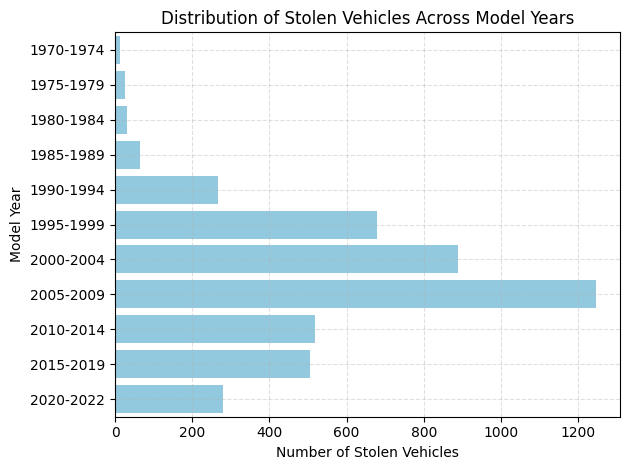

ordered_years
2005-2009    0.275725
2000-2004    0.196725
1995-1999    0.150254
2010-2014    0.114848
2015-2019    0.111529
2020-2022    0.062182
1990-1994    0.058863
1985-1989    0.014162
1980-1984    0.006860
1975-1979    0.005753
1970-1974    0.003098
Name: proportion, dtype: float64

In [8]:
# Create a boolean mask to filter out rows where 'model_year' is between 1940 and 1970
mask = vehicles_df["model_year"] > 1969

# Apply the mask to filter out the rows
vehicles_df_filtered = vehicles_df[mask]

#creating bins and labels for the plot
bins = [1970, 1974, 1979, 1984, 1989, 1994, 1999, 2004, 2009, 2014, 2019, 2022]
labels = ["1970-1974", "1975-1979", "1980-1984", "1985-1989", "1990-1994", "1995-1999", "2000-2004", "2005-2009", "2010-2014", "2015-2019", "2020-2022"]

#Plotting the distribution of stolen vehicles across different model years
vehicles_df_filtered["ordered_years"] = pd.cut(vehicles_df_filtered["model_year"], bins=bins, labels=labels)
sns.countplot(y="ordered_years", data=vehicles_df_filtered, color="skyblue")
plt.title("Distribution of Stolen Vehicles Across Model Years")
plt.xlabel("Number of Stolen Vehicles")
plt.ylabel("Model Year")
plt.grid(axis="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

#viewing the percentage of the ordered_years column
display(vehicles_df_filtered["ordered_years"].value_counts(normalize=True))

Based on this plot, we can see that most of the cars that are stolen come from older vehicles. 2005-2009 being the most stolen vehicle models. The most likely reason is that older vehicles don't have as much advanced technology for security, making them easier targets to steal.

#### Which vehicle makes and models are most frequently stolen?

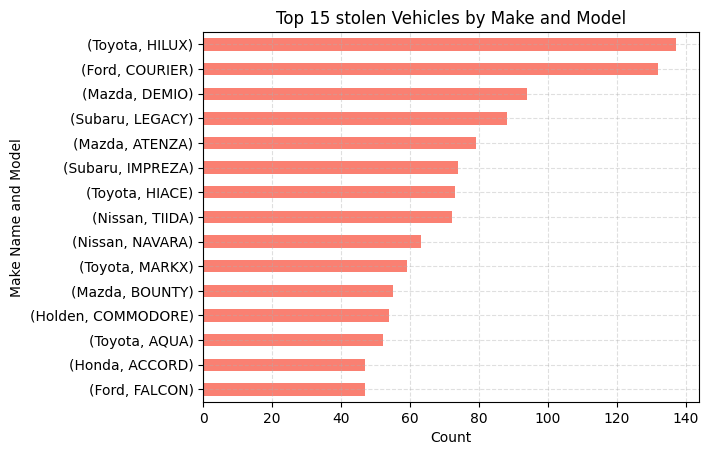

In [9]:
#grouping data by make_name and vehicle_desc
grouped_data = vehicles_df_filtered.groupby(["make_name", "vehicle_desc"])["make_name"].count()

# Getting the top 15 and bottom 15 counts
top_15 = grouped_data.nlargest(15).sort_values()

# Plotting
top_15.plot(kind="barh", color="salmon")
plt.title("Top 15 stolen Vehicles by Make and Model")
plt.xlabel("Count")
plt.ylabel("Make Name and Model")
plt.grid(axis="both", linestyle="--", alpha=0.4)
plt.show()

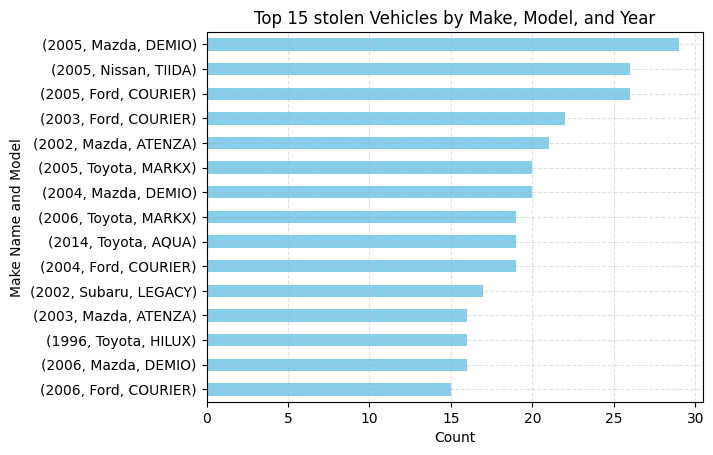

Percentage of the specified car makes relative to all car makes: 41 Percent


In [10]:
#grouping by model_year, make_name, and vehicle_desc
data_grouped = vehicles_df_filtered.groupby(["model_year", "make_name", "vehicle_desc"])["make_name"].count()

#getting top 15 counts
top_15_data = data_grouped.nlargest(15).sort_values()

#plotting
top_15_data.plot(kind='barh', color='skyblue')
plt.title('Top 15 stolen Vehicles by Make, Model, and Year')
plt.xlabel('Count')
plt.ylabel('Make Name and Model')
plt.grid(axis="both", linestyle="--", alpha=0.4)
plt.show()

#calculate the percentage relative to the total occurrences of all car makes
make_counts = vehicles_df_filtered["make_name"].value_counts(normalize=True)
make_percentage = make_counts * 100
make_names = ["Mazda", "Nissan", "Toyota", "Subaru"]
specified_makes_percentage = make_percentage[make_names].sum()
relative_percentage = specified_makes_percentage / make_percentage.sum()

print("Percentage of the specified car makes relative to all car makes:", round(relative_percentage * 100),"Percent")

Taking a closer look at the data implies that over half of the car thefts are coming from japanese car manufacturers.
* Mazda
* Nissan
* Toyota
* Subaru

Ford stands as the sole prominent American manufacturer in this scenario. This prevalence among Japanese brands could be influenced by various factors, including the widespread availability and popularity of these brands, specific vulnerabilities in certain models, and regional variations in market dynamics.

#### Are certain regions more susceptible to higher vehicle theft?

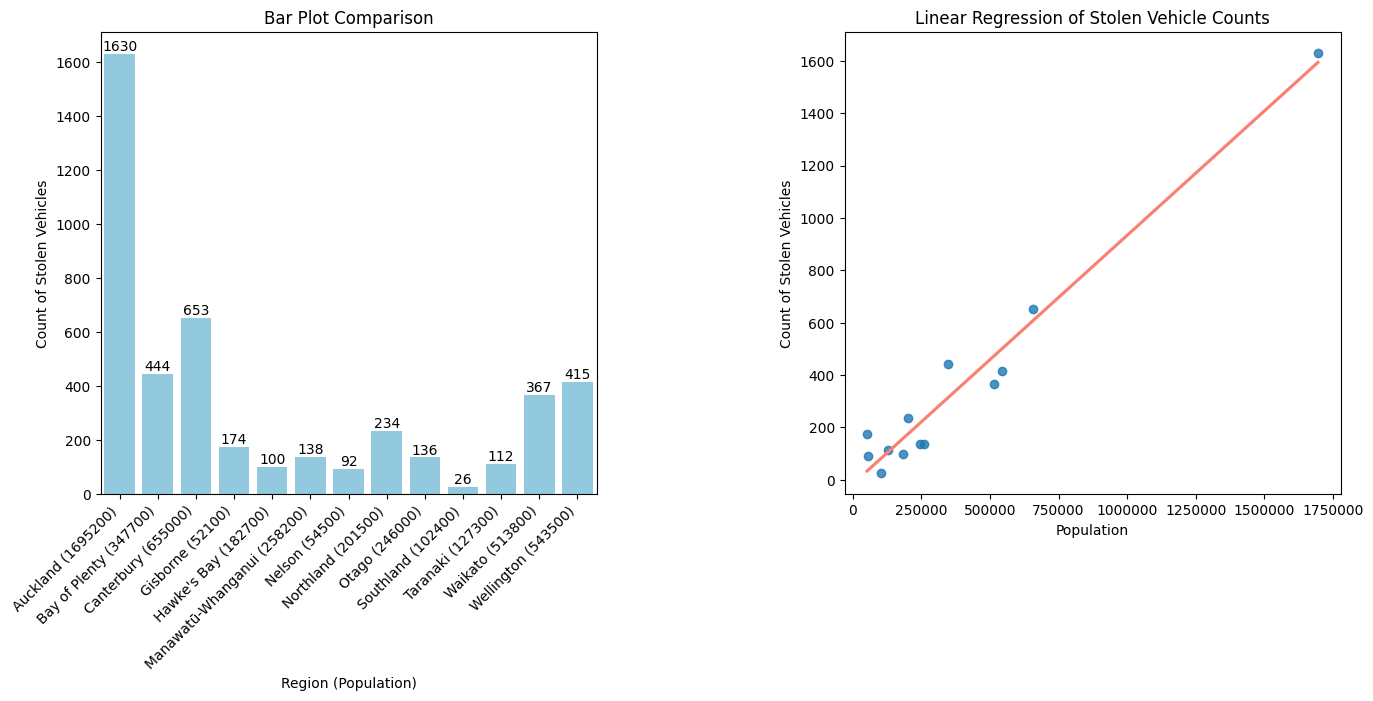

region
Auckland              0.360540
Canterbury            0.144437
Bay of Plenty         0.098208
Wellington            0.091794
Waikato               0.081177
Northland             0.051758
Gisborne              0.038487
Manawatū-Whanganui    0.030524
Otago                 0.030082
Taranaki              0.024773
Hawke's Bay           0.022119
Nelson                0.020349
Southland             0.005751
Name: proportion, dtype: float64

In [11]:
#Grouping by region and population
vehicles_by_region = vehicles_df_filtered.groupby(["region", "population"])["make_name"].count().reset_index(name="vehicle_count")

# Create a new column combining region and population
vehicles_by_region["region_population"] = vehicles_by_region["region"] + " (" + vehicles_by_region["population"].astype(str) + ")"

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Bar plot on the first subplot
sns.barplot(x="region_population", y="vehicle_count", data=vehicles_by_region, ax=ax1, color="skyblue")
ax1.set_ylabel("Count of Stolen Vehicles")
ax1.set_xlabel("Region (Population)")
ax1.set_title("Bar Plot Comparison")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
ax1.bar_label(ax1.containers[0], fontsize=10)

# Linear regression plot on the second subplot
sns.regplot(x="population", y="vehicle_count", data=vehicles_by_region, ax=ax2, scatter=True, ci=None, marker="o", line_kws={"color": "salmon"})
ax2.set_ylabel("Count of Stolen Vehicles")
ax2.set_xlabel("Population")
ax2.set_title("Linear Regression of Stolen Vehicle Counts")

# Remove scientific notation from x-axis
ax2.get_xaxis().get_major_formatter().set_scientific(False)

# Adjusting spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.show()

#displaying the percentage of vehicles thefts in each region
display(vehicles_df_filtered["region"].value_counts(normalize=True))

The regression model tells us that there is a positive relationship between population size and the number of vehicles that are stolen. Regions with a greter population size will have higher vehicle thefts. Furthermore, we can see that there is an outlier coming from Auckland with a population of 1,695,200. The smallest amount of vehicle thefts is coming from Southland with the smallest population size, 102,400.

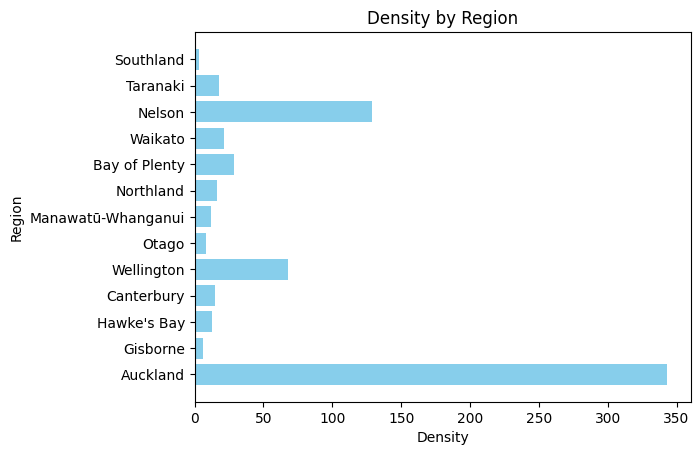

In [12]:
#comparing density by region with a bar plot
plt.barh(width="density", y="region", data=vehicles_df_filtered, color="skyblue")
plt.xlabel("Density")
plt.ylabel("Region")
plt.title("Density by Region")
plt.show()

It is evident that Auckland exhibits significantly higher population density compared to other regions. This higher density correlates with a greater number of residents, thereby suggesting a heightened likelihood of vehicle thefts per capita.

#### Is there a pattern in the days or months when vehicle thefts are more likely to occur?

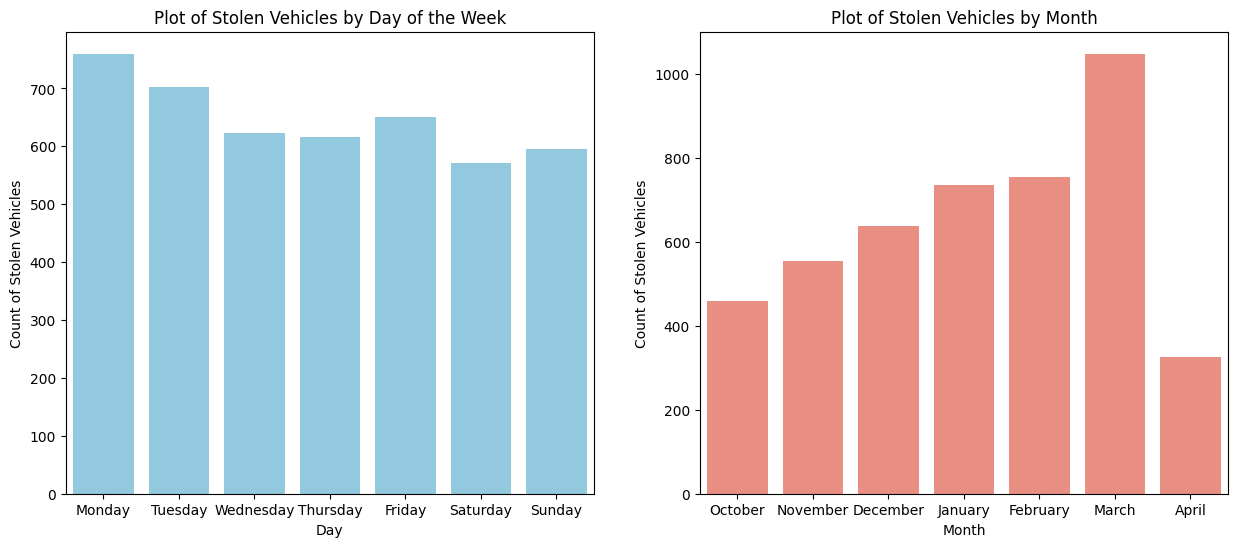

date_stolen
March       1049
February     755
January      736
December     639
November     556
October      460
April        326
Name: count, dtype: int64

In [13]:
#subsetting day and months into their own variable
day = vehicles_df_filtered["date_stolen"].dt.day
month_names = vehicles_df_filtered["date_stolen"].dt.month_name()
dow = vehicles_df_filtered["date_stolen"].dt.day_name()

#creating weekday list
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

#creating month list
month_order = ["October", "November", "December", "January", "February", "March", "April"]

#plotting on the first subplot
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6))
sns.countplot(x=dow, data=vehicles_df_filtered, ax=ax1, order=weekday_order, color="skyblue")
ax1.set_title("Plot of Stolen Vehicles by Day of the Week")
ax1.set_xlabel("Day")
ax1.set_ylabel("Count of Stolen Vehicles")

#plotting on the second subplot
sns.countplot(x=month_names, data=vehicles_df_filtered, ax=ax2, order=month_order, color="salmon")
ax2.set_title("Plot of Stolen Vehicles by Month")
ax2.set_xlabel("Month")
ax2.set_ylabel("Count of Stolen Vehicles")
plt.show()

#viewing the counts of stolen vehicles by month
display(month_names.value_counts())

Side not: This dataframe only includes 7 months and two years, 2021 and 2022. I won't be analyzing the years since there is only two. Additionally, there is also no available data on May, June, July, August, and September.

With that being said, vehicle theft rates are slightly higher on Mondays and Tuesdays compared to the rest of the week. March peaks with the highest number of car thefts, while April sees a notable decrease, with a third as many incidents.

#### Which colors are most commonly associated with stolen vehicles?

In [14]:
#displaying the counts of each car stolen by color
display(vehicles_df_filtered["color"].value_counts())

color
Silver    1271
White      929
Black      589
Blue       510
Red        388
Grey       374
Green      222
Gold        77
Brown       49
Yellow      39
Orange      35
Purple      26
Cream        8
Pink         4
Name: count, dtype: int64

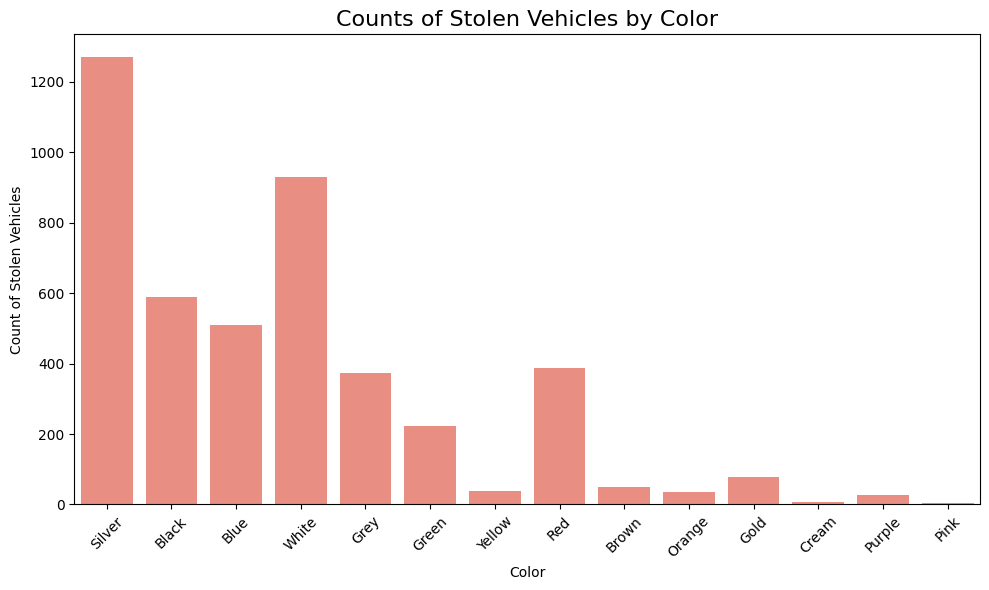

Percentage of the specified car colors relative to all of the other color: 62 Percent


In [15]:
# Plotting a bar plot of stolen vehicles by color
plt.figure(figsize=(10, 6))
sns.countplot(x="color", data=vehicles_df_filtered, color="salmon")
plt.title("Counts of Stolen Vehicles by Color", fontsize=16)
plt.xlabel("Color")
plt.ylabel("Count of Stolen Vehicles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#calculate the percentage relative to the total occurrences of all car makes
color_counts = vehicles_df_filtered["color"].value_counts(normalize=True)
color_percentage = color_counts * 100
color_names = ["Silver", "White", "Black"]
specified_color_percentage = color_percentage[color_names].sum()
relative_percentage = specified_color_percentage / color_percentage.sum()

print("Percentage of the specified car colors relative to all of the other color:", round(relative_percentage * 100),"Percent")

Silver, white, and black vehicles are among the most commonly stolen mostly due to their popularity, resale value, and visibility. These colors are widely chosen by consumers, making them abundant on the road and providing more opportunities for theft. Additionally, these colors often command high resale prices and are in demand in the used car market, incentivizing theft.

# III. Summary

In our analysis of vehicle thefts in New Zealand, several key insights emerge:

* The preponderance of stolen vehicles comprises older models, with 27.5% stemming from the 2005-2009 period.
* Japanese manufacturers, including Mazda, Toyota, Subaru, and Nissan, account for 41% of all stolen vehicles.
* Auckland stands out as the region with the highest incidence of vehicle thefts, comprising 36% of total thefts relative to other regions.
* Although Mondays exhibit a slight uptick in thefts, overall, the distribution of thefts throughout the week remains fairly uniform.
* March records the highest number of vehicle thefts, totaling 1020 cases, while April sees the fewest, with 326 incidents.
* Notably, silver, white, and black vehicles constitute the majority of stolen vehicles, comprising 62% of the dataset.

In conclusion, these findings underscore the importance of vigilance and security measures, particularly for owners of older model vehicles and those in Auckland. Awareness of peak theft periods and popular vehicle colors can aid in the prevention and recovery efforts against car theft.